In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
class LJ(object):
    '''Class to simulate LJ system'''
    
    def __init__(self, N, dim):
        self.numParticles = N
        self.dim = dim
        self.positions = np.zeros( (N,dim))
        self.velocities = np.zeros( (N,dim))
        self.forces = np.zeros( (N,dim))
        self.lj_sigma = 1.0
        self.lj_epsilon = 1.0
        self.kT = 1.0
        self.boxL = 10
        
    def position_initialization(self, boxL):
        '''initialise the positions of particles randomly, in a boxL size box '''
        self.boxL = boxL
        self.positions = np.random.random_sample( (self.numParticles, self.dim))* boxL
        
    def velocities_MaxwellBoltzmann(self, kT):
        '''initialize velocities to Maxwell-Boltzmann distrition at temp kT'''
        factor = sqrt(kT)
        self.velocities = factor*np.random.normal(0.,1.,size=( (self.numParticles,self.dim)))

        
    def force_two_particles(self, p_i, p_j):
        '''compute the force of interaction between particles p_i and p_j due to LJ'''        
        rvec_ij = self.positions[p_i] - self.positions[p_j]
        d_ij = np.linalg.norm( rvec_ij )        
        s6 = pow(self.lj_sigma/d_ij , 6)        
        factor = 24* self.lj_epsilon * s6 *(2 * s6 -1 )        
        return factor*rvec_ij/pow(d_ij,2)
    
    def calcForces(self):
        ''' calcaulte the forces on all particles of the system'''
                        
        self.forces *= 0        
        for idx, vec in enumerate(self.positions):
            r = np.linalg.norm(vec - self.positions, axis = 1)
            r = np.delete(r, idx)
            position_temp = np.delete(vec - self.positions, idx, 0)
            force_mag = 24*self.lj_epsilon*( 2*((self.lj_sigma/r)**12) - ((self.lj_sigma/r)**6) )/(r*r)
            self.forces[idx]= np.sum(position_temp*force_mag [:, None], axis = 0)
        return 
                
    def EulerIntegrate(self, dt):
        '''Euler interation with timestep dt'''
        
        self.calcForces()
        self.positions += dt * self.velocities
        self.velocities += dt * self.forces 
        
    def configDraw(self):        

        figure(figsize=(5,5))
        axis = gca()
        axis.set_xlim(-5,self.boxL+5)
        axis.set_ylim(-5,self.boxL+5)        
        circles = []
        for i in range(self.numParticles):
            circles.append( axis.add_patch( Circle(self.positions[i], radius=0.5, 
                                                   linewidth=2, edgecolor='black') ) )
        show()
        
    def minimize(self, dist_max):
        '''randomly selecting a particle, dispacing it randomly and 
        accept the move if energy is lower, reject otherwise'''

        p_i = np.random.randint(0,self.numParticles)
        dr = (2*np.random.random( (self.dim, ))-1)*dist_max
        
        pe_before = self.pe_interaction(p_i)
        self.positions[p_i] += dr
        pe_after = self.pe_interaction(p_i)
        
        if (pe_after > pe_before): #undo the move
            self.positions[p_i] -= dr
            
    def pe_interaction(self, p_i):
        ''' interaction energy of particle p_i with all other particles'''
        pe = 0.0
        for p_j in range(self.numParticles):
            if (p_j != p_i): 
                pe +=  self.pe_twoParticle_LJ(p_i,p_j)
        return pe
    
    def pe_twoParticle_LJ(self,p_i,p_j):
        '''LJ interaction energy between particle p_i and p_j'''
        d_ij = np.linalg.norm ( self.positions[p_i] - self.positions[p_j])
        s6 = pow(self.lj_sigma / d_ij, 6)
        return 4*self.lj_epsilon*s6*(s6-1)
    
    def totalPE(self):
        '''calculate the total potential energy of the system'''
        pe = 0.0
        for p_j in range(self.numParticles):
            for p_i in range(p_j):
                pe +=  self.pe_twoParticle_LJ(p_i,p_j)
        return pe
    
    def totalKE(self):
        '''calculate the total Kinteic Energy of the system'''
        return 0.5* np.sum( self.velocities **2 )
    
    
    def velocityVerletIntegrate(self,dt):
        self.calcForces()
        self.velocities += 0.5*dt*self.forces
        self.positions +=  dt*self.velocities
        self.calcForces()
        self.velocities += 0.5*dt*self.forces
        
    def Metropolis_scheme(self, dist_max):
        '''Markov Chain using Metropolis scheme.
        Randomly select a particle and displace it randomly with dist_max'''        
        # select a particle randomly
        p_i = np.random.randint(0, self.numParticles)        
        # select a random displacment
        dr = (2*np.random.random_sample( (self.dim,))-1)*dist_max        
        # compute del_E
        pe_before = self.pe_interaction(p_i)
        self.positions[p_i] += dr
        pe_after = self.pe_interaction(p_i)
        del_E = pe_after - pe_before        
        # compute accept/reject
        ## implment change in config accordingly
        prob_accept = min(1.0, np.exp(-del_E/self.kT))
        if np.random.random() > prob_accept: 
            #reject
            self.positions[p_i] -= dr        
        return
    
    def calc_temperature(self):
        temp = 2 * self.totalKE()
        temp /= self.kT*(3*self.numParticles - 3)
        return temp
    
    def calc_volume(self):
        pres = self.Calc_virial(self.boxL)
        temp = self.calc_temperature()
        return ((self.numParticles*temp)/pres)    
    
    def Calc_virial(self,boxL):
        self.calcForces()
        volume = np.zeros(self.dim)
        # get max position from all the axes
        for i in range(self.dim):
            volume[i] -= min(self.positions[:,i])    
            volume[i] += max(self.positions[:,i])         
        vol_prod = np.prod(volume)
        abs_vol = np.absolute(vol_prod)
        volume = abs_vol
        dv = self.dim*volume
        p = (self.kT*self.numParticles)/volume
        for i in range(self.numParticles):
            for j in range(i):
                p+= (1/dv)*(np.dot(self.force_two_particles(i,j),(self.positions[i]-self.positions[j])))
        return p

# 2-dim

In [3]:
sample1 = LJ(64, 2)

In [4]:
sample1.boxL = 10
sample1.position_initialization(10)
sample1.velocities_MaxwellBoltzmann(0.001)

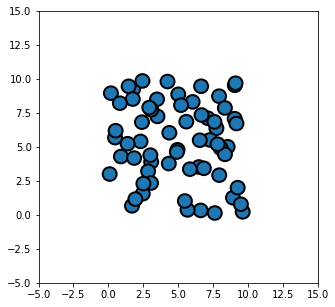

In [5]:
sample1.configDraw()
# plotted for a better intutive understanding

In [6]:
# minimization
for i in range(1000):
    sample1.minimize(0.1)

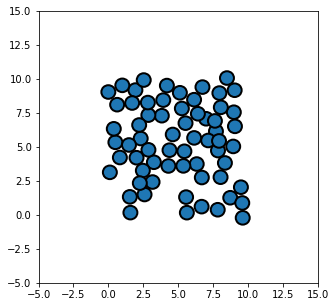

In [7]:
sample1.configDraw()
# plotted for a better intuitive understanding

In [8]:
# studying Equilibriration & Productions
E_pot = []
for i in range(2000):
    sample1.velocityVerletIntegrate(0.001)
    E_pot.append(sample1.totalPE())

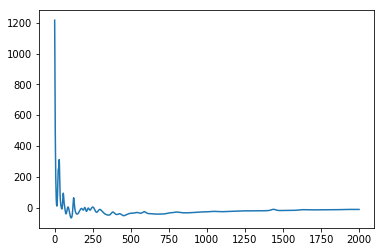

In [9]:
plot(E_pot, "-")

In [10]:
# calculations for further analysis
temp1, pres1, vol1 = [], [], []
for i in range(1000):
    sample1.velocityVerletIntegrate(0.001)
    temp1.append(sample1.calc_temperature())
    pres1.append(sample1.Calc_virial(10))
    vol1.append(sample1.calc_volume())

### Temperature

The Avg. temperature of the simulation is: 14.047109756646728K


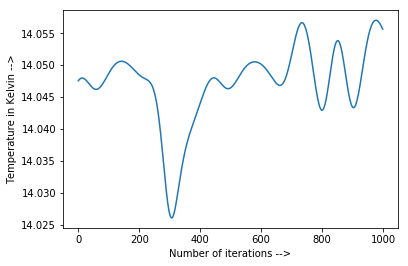

In [11]:
plot(temp1)
ylabel("Temperature in Kelvin -->")
xlabel("Number of iterations -->")
temp2d_avg = np.sum(temp1)/len(temp1)
print("The Avg. temperature of the simulation is: " + str(temp2d_avg) + "K")

### Area

The area of the droplet formed is: 103436.10345081831


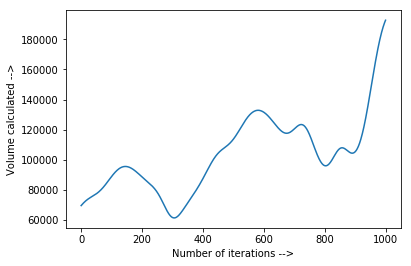

In [12]:
plot(vol1)
ylabel("Volume calculated -->")
xlabel("Number of iterations -->")
vol2d_avg = np.sum(vol1)/len(vol1)
print( "The area of the droplet formed is: " + str(vol2d_avg))

### Pressure

Text(0.5,0,'Number of iterations -->')

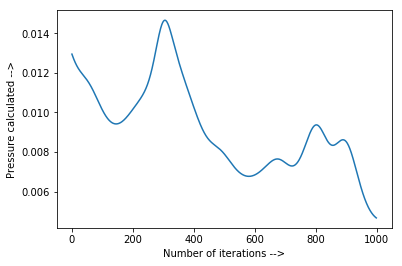

In [13]:
plot(pres1)
ylabel("Pressure calculated -->")
xlabel("Number of iterations -->")

# 3-dim

In [14]:
sample2 = LJ(64, 3)

In [15]:
sample2.boxL = 10
sample2.position_initialization(10)
sample2.velocities_MaxwellBoltzmann(0.001)

In [16]:
# minimization
for i in range(1000):
    sample2.minimize(0.1)

In [17]:
# studying Equilibriration & Productions
E_pot = []
for i in range(2000):
    sample2.velocityVerletIntegrate(0.001)
    E_pot.append(sample2.totalPE())

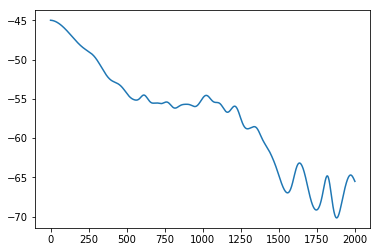

In [18]:
plot(E_pot)

In [19]:
# calculations for further analysis
temp2, pres2, vol2 = [], [], []
for i in range(1000):
    sample2.velocityVerletIntegrate(0.001)
    temp2.append(sample2.calc_temperature())
    pres2.append(sample2.Calc_virial(10))
    vol2.append(sample2.calc_volume())

### Temperature

The Avg. temperature of the simulation is: 0.24721589267719887K


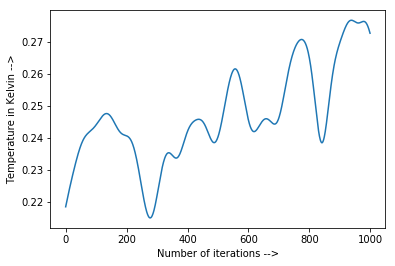

In [20]:
plot(temp2)
ylabel("Temperature in Kelvin -->")
xlabel("Number of iterations -->")
temp3d_avg = np.sum(temp2)/len(temp2)
print("The Avg. temperature of the simulation is: " + str(temp3d_avg) + "K")

### Volume

The volume of the droplet formed is: 273.03568026784296


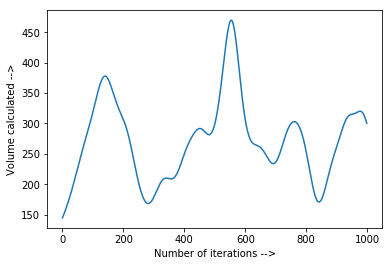

In [21]:
plot(vol2)
ylabel("Volume calculated -->")
xlabel("Number of iterations -->")
vol3d_avg = np.sum(vol2)/len(vol2)
print( "The volume of the droplet formed is: " + str(vol3d_avg))

### Pressure

Text(0.5,0,'Number of iterations -->')

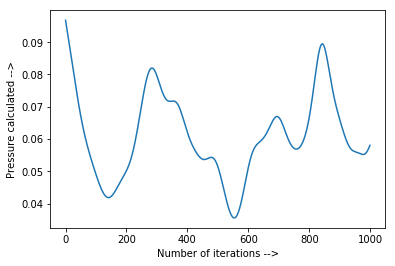

In [22]:
plot(pres2)
ylabel("Pressure calculated -->")
xlabel("Number of iterations -->")